In [1]:
import os
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# get image filepaths
pangolin_path = "./Pangolin_Images_3_12"
other_path = "./Other_Images_3_12"

pangolin_images = os.listdir(pangolin_path)
other_images = os.listdir(other_path)
print(len(pangolin_images), pangolin_images)
print(len(other_images), other_images)

206 ['IMG_0006.JPG', 'IMG_0015.JPG', 'IMG_0016.JPG', 'IMG_0017.JPG', 'IMG_0018.JPG', 'IMG_0153.JPG', 'IMG_0155.JPG', 'IMG_0156.JPG', 'IMG_0157.JPG', 'IMG_0158.JPG', 'IMG_0159.JPG', 'IMG_0160.JPG', 'IMG_0161.JPG', 'IMG_0162.JPG', 'IMG_0179.JPG', 'IMG_0180.JPG', 'IMG_0181.JPG', 'IMG_0182.JPG', 'IMG_0236.JPG', 'IMG_0247.JPG', 'IMG_0251.JPG', 'IMG_0252.JPG', 'IMG_0253.JPG', 'IMG_0254.JPG', 'IMG_0255.JPG', 'IMG_0256.JPG', 'IMG_0257.JPG', 'IMG_0258.JPG', 'IMG_0259.JPG', 'IMG_0271.JPG', 'IMG_0416.JPG', 'IMG_0417.JPG', 'IMG_0418.JPG', 'IMG_0420.JPG', 'IMG_0422.JPG', 'IMG_0423.JPG', 'IMG_0424.JPG', 'IMG_0425.JPG', 'IMG_0426.JPG', 'IMG_0549.JPG', 'IMG_0550.JPG', 'IMG_0551.JPG', 'IMG_0552.JPG', 'IMG_0553.JPG', 'IMG_0554.JPG', 'IMG_0555.JPG', 'IMG_0556.JPG', 'IMG_0557.JPG', 'IMG_0558.JPG', 'IMG_0559.JPG', 'IMG_0560.JPG', 'IMG_0561.JPG', 'IMG_0562.JPG', 'IMG_0563.JPG', 'IMG_0564.JPG', 'IMG_0577.JPG', 'IMG_0578.JPG', 'IMG_0579.JPG', 'IMG_0581.JPG', 'IMG_0582.JPG', 'IMG_0583.JPG', 'IMG_0584.JPG', 'IM

In [ ]:
# combine filepath and label
data = ([(os.path.join(pangolin_path, img), 1) for img in pangolin_images if img != ".DS_Store"] +
    [(os.path.join(other_path, img), 0) for img in other_images])

print(data)
print(len(data))

[('./Pangolin_Images_3_12\\IMG_0006.JPG', 1), ('./Pangolin_Images_3_12\\IMG_0015.JPG', 1), ('./Pangolin_Images_3_12\\IMG_0016.JPG', 1), ('./Pangolin_Images_3_12\\IMG_0017.JPG', 1), ('./Pangolin_Images_3_12\\IMG_0018.JPG', 1), ('./Pangolin_Images_3_12\\IMG_0153.JPG', 1), ('./Pangolin_Images_3_12\\IMG_0155.JPG', 1), ('./Pangolin_Images_3_12\\IMG_0156.JPG', 1), ('./Pangolin_Images_3_12\\IMG_0157.JPG', 1), ('./Pangolin_Images_3_12\\IMG_0158.JPG', 1), ('./Pangolin_Images_3_12\\IMG_0159.JPG', 1), ('./Pangolin_Images_3_12\\IMG_0160.JPG', 1), ('./Pangolin_Images_3_12\\IMG_0161.JPG', 1), ('./Pangolin_Images_3_12\\IMG_0162.JPG', 1), ('./Pangolin_Images_3_12\\IMG_0179.JPG', 1), ('./Pangolin_Images_3_12\\IMG_0180.JPG', 1), ('./Pangolin_Images_3_12\\IMG_0181.JPG', 1), ('./Pangolin_Images_3_12\\IMG_0182.JPG', 1), ('./Pangolin_Images_3_12\\IMG_0236.JPG', 1), ('./Pangolin_Images_3_12\\IMG_0247.JPG', 1), ('./Pangolin_Images_3_12\\IMG_0251.JPG', 1), ('./Pangolin_Images_3_12\\IMG_0252.JPG', 1), ('./Pango

In [ ]:
# create and write column headers to csv files for logging purposes
import csv
log_folder_path = "./log"
os.makedirs(log_folder_path, exist_ok=True)

train_csv_file_path = log_folder_path + "/train_scoresv2.csv"
time_csv_file_path = log_folder_path + "/time_per_epochv2.csv"
test_csv_file_path = log_folder_path + "/test_scoresv2.csv"
loss_csv_file_path = log_folder_path + "/loss_per_epochv2.csv"

train_csv = open(train_csv_file_path, mode='w', newline='')
time_csv = open(time_csv_file_path, mode='w', newline='')
test_csv = open(test_csv_file_path, mode='w', newline='')
loss_csv = open(loss_csv_file_path, mode='w', newline='')

train_writer = csv.writer(train_csv)
time_writer = csv.writer(time_csv)
test_writer = csv.writer(test_csv)
loss_writer = csv.writer(loss_csv)

train_writer.writerow([
    'fold', 'epoch',
    'accuracy_pangolin', 'accuracy_other',
    'recall_pangolin', 'recall_other',
    'precision_pangolin', 'precision_other',
    'f1_pangolin', 'f1_other',
    'auc_pangolin', 'auc_other'
])
time_writer.writerow(['fold', 'epoch', 'time'])
test_writer.writerow([
    'fold',
    'accuracy_pangolin', 'accuracy_other',
    'recall_pangolin', 'recall_other',
    'precision_pangolin', 'precision_other',
    'f1_pangolin', 'f1_other',
    'auc_pangolin', 'auc_other'
])
loss_writer.writerow(['fold', 'epoch', 'train_loss', 'val_loss'])

32

In [5]:
train_csv.flush()
time_csv.flush()
test_csv.flush()
loss_csv.flush()

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
)

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# plot image of misclassifications
def plot_misclassified(fold, pred, data):
    true = [label for _, label in data]
    fn_indices = [i for i, (p, t) in enumerate(zip(pred, true)) if p == 0 and t == 1]   # false negatives
    fp_indices = [i for i, (p, t) in enumerate(zip(pred, true)) if p == 1 and t == 0]   # false positives

    # helper method to plot image
    def plot_images(indices, title):
        if not indices:
            print(f"No Misclassified Samples Found: " + title)
            return
        
        fig, axes = plt.subplots(1, len(indices), figsize=(15, 5))
        if len(indices) == 1:
            axes = [axes]
        
        for ax, idx in zip(axes, indices):
            filename, true_label = data[idx]
            img = Image.open(filename)
            
            ax.imshow(img)
            ax.axis("off")
            ax.set_title(f"{title}\nPred: {pred[idx]}, True: {true_label}", fontsize=10)
        plt.show()

    # plot images
    plot_images(fn_indices, "Fold " + str(fold + 1) + ": False Negatives")
    plot_images(fp_indices, "Fold " + str(fold + 1) + ": False Positives")

###############################################################################################################################################
# printing/logging methods (different for validation, training, and testing because they have different ways to log to csv files)
###############################################################################################################################################

# prints score for validation
def print_scores(true, pred, prob):
    # calculating scores for pangolin class
    accuracy = accuracy_score(true, pred)
    pangolin_precision = precision_score(true, pred, pos_label=1, zero_division=0)
    pangolin_recall = recall_score(true, pred, pos_label=1, zero_division=0)
    pangolin_f1 = f1_score(true, pred, pos_label=1, zero_division=0)
    pangolin_prob = prob[:, 1]
    pangolin_auc = roc_auc_score(true, pangolin_prob)

    print(f"\tpangolin accuracy: {accuracy:.4f}")
    print(f"\tpangolin precision: {pangolin_precision:.4f}")
    print(f"\tpangolin recall: {pangolin_recall:.4f}")
    print(f"\tpangolin f1-score: {pangolin_f1:.4f}")
    print(f"\tpangolin auc: {pangolin_auc:.4f}")

    # calculating scores for other class
    other_precision = precision_score(true, pred, pos_label=0, zero_division=0)
    other_recall = recall_score(true, pred, pos_label=0, zero_division=0)
    other_f1 = f1_score(true, pred, pos_label=0, zero_division=0)

    other_prob = prob[:, 0]
    true_inverted = [1 if t != 1 else 0 for t in true]
    other_auc = roc_auc_score(true_inverted, other_prob)

    print(f"\tother accuracy: {accuracy:.4f}")
    print(f"\tother precision: {other_precision:.4f}")
    print(f"\tother recall: {other_recall:.4f}")
    print(f"\tother f1-score: {other_f1:.4f}")
    print(f"\tother auc: {other_auc:.4f}")

# print and log score for training
def train_print_and_log_scores(fold, epoch, true, pred, prob):
    # calculating scores for pangolin class
    accuracy = accuracy_score(true, pred)
    pangolin_precision = precision_score(true, pred, pos_label=1, zero_division=0)
    pangolin_recall = recall_score(true, pred, pos_label=1, zero_division=0)
    pangolin_f1 = f1_score(true, pred, pos_label=1, zero_division=0)
    pangolin_prob = prob[:, 1].detach().numpy()
    pangolin_auc = roc_auc_score(true, pangolin_prob)

    print(f"\tpangolin accuracy: {accuracy:.4f}")
    print(f"\tpangolin precision: {pangolin_precision:.4f}")
    print(f"\tpangolin recall: {pangolin_recall:.4f}")
    print(f"\tpangolin f1-score: {pangolin_f1:.4f}")
    print(f"\tpangolin auc: {pangolin_auc:.4f}")

    # calculating scores for other class
    other_precision = precision_score(true, pred, pos_label=0, zero_division=0)
    other_recall = recall_score(true, pred, pos_label=0, zero_division=0)
    other_f1 = f1_score(true, pred, pos_label=0, zero_division=0)
    other_prob = prob[:, 0].detach().numpy()
    true_inverted = (true != 1).detach().numpy().astype(int)  
    other_auc = roc_auc_score(true_inverted, other_prob)

    print(f"\tother accuracy: {accuracy:.4f}")
    print(f"\tother precision: {other_precision:.4f}")
    print(f"\tother recall: {other_recall:.4f}")
    print(f"\tother f1-score: {other_f1:.4f}")
    print(f"\tother auc: {other_auc:.4f}")

    # writing to csv file
    train_writer.writerow([
        fold, epoch,
        accuracy, accuracy,
        pangolin_recall, other_recall,
        pangolin_precision, other_precision,
        pangolin_f1, other_f1,
        pangolin_auc, other_auc
    ])

# print and log scores for testing
def test_print_and_log_scores(fold, true, pred, prob):
    # calculating scores for pangolin class
    accuracy = accuracy_score(true, pred)
    pangolin_precision = precision_score(true, pred, pos_label=1, zero_division=0)
    pangolin_recall = recall_score(true, pred, pos_label=1, zero_division=0)
    pangolin_f1 = f1_score(true, pred, pos_label=1, zero_division=0)
    pangolin_prob = prob[:, 1]
    pangolin_auc = roc_auc_score(true, pangolin_prob)

    print(f"\tpangolin accuracy: {accuracy:.4f}")
    print(f"\tpangolin precision: {pangolin_precision:.4f}")
    print(f"\tpangolin recall: {pangolin_recall:.4f}")
    print(f"\tpangolin f1-score: {pangolin_f1:.4f}")
    print(f"\tpangolin auc: {pangolin_auc:.4f}")

    # calculating scores for other class
    other_precision = precision_score(true, pred, pos_label=0, zero_division=0)
    other_recall = recall_score(true, pred, pos_label=0, zero_division=0)
    other_f1 = f1_score(true, pred, pos_label=0, zero_division=0)
    other_prob = prob[:, 0]
    true_inverted = [1 if t != 1 else 0 for t in true]
    other_auc = roc_auc_score(true_inverted, other_prob)

    print(f"\tother accuracy: {accuracy:.4f}")
    print(f"\tother precision: {other_precision:.4f}")
    print(f"\tother recall: {other_recall:.4f}")
    print(f"\tother f1-score: {other_f1:.4f}")
    print(f"\tother auc: {other_auc:.4f}")

    # writing to csv file
    test_writer.writerow([
        fold,
        accuracy, accuracy,
        pangolin_recall, other_recall,
        pangolin_precision, other_precision,
        pangolin_f1, other_f1,
        pangolin_auc, other_auc
    ])

# custom collate function for the data loader
def collate_fn(batch):
    images = torch.stack([item["image"] for item in batch])
    labels = torch.tensor([item["label"] for item in batch], dtype=torch.long)
    image_ids = [item["image_id"] for item in batch]

    return {"image": images, "label": labels, "image_id": image_ids}

# custom image dataset
class ImagesDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __getitem__(self, index):
        filepath, label = self.data[index]
        image = Image.open(filepath).convert("RGB")
        image = self.transform(image)
        label = torch.tensor(label, dtype=torch.long)
        sample = {"image": image, "label": label, "image_id": index}
        return sample

    def __len__(self):
        return len(self.data)


In [ ]:
num_epochs = 15

In [ ]:
import torch.optim as optim
from torch import nn
import torchvision.models as models
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import time

pretrained_model = "../checkpoint_inat21-mini_90epoch_r50_image-only_67.924_top1_acc.pth"       # filepath to pretrained model check point
model_folder_path = "./models"      # create folder to store optimal model per fold
os.makedirs(model_folder_path, exist_ok=True)

In [ ]:
# read cross validation indices from stored csv file
df_splits = pd.read_csv("crossval_splits.csv")
print(df_splits)

      fold  index   type
0        0    375  train
1        0    112  train
2        0     35  train
3        0    221  train
4        0    426  train
...    ...    ...    ...
3260     4    634   test
3261     4    636   test
3262     4    641   test
3263     4    645   test
3264     4    648   test

[3265 rows x 3 columns]




fold 1 -------------------------------------------------------------------------------------------------

epoch 1
TRAINING


100%|██████████| 15/15 [02:14<00:00,  8.99s/it]


	training loss: 0.6112
	pangolin accuracy: 0.7143
	pangolin precision: 0.0000
	pangolin recall: 0.0000
	pangolin f1-score: 0.0000
	pangolin auc: 0.9111
	other accuracy: 0.7143
	other precision: 0.7143
	other recall: 1.0000
	other f1-score: 0.8333
	other auc: 0.9111
VALIDATION


100%|██████████| 2/2 [00:11<00:00,  5.78s/it]


	validation loss: 0.5462
	pangolin accuracy: 0.6792
	pangolin precision: 0.0000
	pangolin recall: 0.0000
	pangolin f1-score: 0.0000
	pangolin auc: 0.8578
	other accuracy: 0.6792
	other precision: 0.6792
	other recall: 1.0000
	other f1-score: 0.8090
	other auc: 0.8578

epoch 2
TRAINING


100%|██████████| 15/15 [02:54<00:00, 11.63s/it]


	training loss: 0.4254
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.05s/it]


	validation loss: 0.3878
	pangolin accuracy: 0.8679
	pangolin precision: 0.8571
	pangolin recall: 0.7059
	pangolin f1-score: 0.7742
	pangolin auc: 0.9379
	other accuracy: 0.8679
	other precision: 0.8718
	other recall: 0.9444
	other f1-score: 0.9067
	other auc: 0.9379

epoch 3
TRAINING


100%|██████████| 15/15 [02:26<00:00,  9.76s/it]


	training loss: 0.3181
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.09s/it]


	validation loss: 0.2851
	pangolin accuracy: 0.9811
	pangolin precision: 0.9444
	pangolin recall: 1.0000
	pangolin f1-score: 0.9714
	pangolin auc: 0.9869
	other accuracy: 0.9811
	other precision: 1.0000
	other recall: 0.9722
	other f1-score: 0.9859
	other auc: 0.9869

epoch 4
TRAINING


100%|██████████| 15/15 [02:38<00:00, 10.59s/it]


	training loss: 0.2316
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.48s/it]


	validation loss: 0.1980
	pangolin accuracy: 0.9811
	pangolin precision: 0.9444
	pangolin recall: 1.0000
	pangolin f1-score: 0.9714
	pangolin auc: 0.9902
	other accuracy: 0.9811
	other precision: 1.0000
	other recall: 0.9722
	other f1-score: 0.9859
	other auc: 0.9902

epoch 5
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.79s/it]


	training loss: 0.1515
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.45s/it]


	validation loss: 0.1240
	pangolin accuracy: 0.9811
	pangolin precision: 0.9444
	pangolin recall: 1.0000
	pangolin f1-score: 0.9714
	pangolin auc: 0.9984
	other accuracy: 0.9811
	other precision: 1.0000
	other recall: 0.9722
	other f1-score: 0.9859
	other auc: 0.9984

epoch 6
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.76s/it]


	training loss: 0.0871
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.45s/it]


	validation loss: 0.0770
	pangolin accuracy: 0.9811
	pangolin precision: 0.9444
	pangolin recall: 1.0000
	pangolin f1-score: 0.9714
	pangolin auc: 1.0000
	other accuracy: 0.9811
	other precision: 1.0000
	other recall: 0.9722
	other f1-score: 0.9859
	other auc: 1.0000

epoch 7
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.73s/it]


	training loss: 0.0528
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.49s/it]


	validation loss: 0.0504
	pangolin accuracy: 0.9811
	pangolin precision: 0.9444
	pangolin recall: 1.0000
	pangolin f1-score: 0.9714
	pangolin auc: 1.0000
	other accuracy: 0.9811
	other precision: 1.0000
	other recall: 0.9722
	other f1-score: 0.9859
	other auc: 1.0000

epoch 8
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.78s/it]


	training loss: 0.0326
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:11<00:00,  5.50s/it]


	validation loss: 0.0387
	pangolin accuracy: 0.9811
	pangolin precision: 0.9444
	pangolin recall: 1.0000
	pangolin f1-score: 0.9714
	pangolin auc: 1.0000
	other accuracy: 0.9811
	other precision: 1.0000
	other recall: 0.9722
	other f1-score: 0.9859
	other auc: 1.0000

epoch 9
TRAINING


100%|██████████| 15/15 [02:40<00:00, 10.68s/it]


	training loss: 0.0200
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.41s/it]


	validation loss: 0.0296
	pangolin accuracy: 0.9811
	pangolin precision: 0.9444
	pangolin recall: 1.0000
	pangolin f1-score: 0.9714
	pangolin auc: 1.0000
	other accuracy: 0.9811
	other precision: 1.0000
	other recall: 0.9722
	other f1-score: 0.9859
	other auc: 1.0000

epoch 10
TRAINING


100%|██████████| 15/15 [02:42<00:00, 10.85s/it]


	training loss: 0.0151
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:11<00:00,  5.70s/it]


	validation loss: 0.0262
	pangolin accuracy: 0.9811
	pangolin precision: 0.9444
	pangolin recall: 1.0000
	pangolin f1-score: 0.9714
	pangolin auc: 1.0000
	other accuracy: 0.9811
	other precision: 1.0000
	other recall: 0.9722
	other f1-score: 0.9859
	other auc: 1.0000

epoch 11
TRAINING


100%|██████████| 15/15 [02:42<00:00, 10.85s/it]


	training loss: 0.0126
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.24s/it]


	validation loss: 0.0255
	pangolin accuracy: 0.9811
	pangolin precision: 0.9444
	pangolin recall: 1.0000
	pangolin f1-score: 0.9714
	pangolin auc: 1.0000
	other accuracy: 0.9811
	other precision: 1.0000
	other recall: 0.9722
	other f1-score: 0.9859
	other auc: 1.0000

epoch 12
TRAINING


100%|██████████| 15/15 [02:39<00:00, 10.66s/it]


	training loss: 0.0099
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.32s/it]


	validation loss: 0.0222
	pangolin accuracy: 0.9811
	pangolin precision: 0.9444
	pangolin recall: 1.0000
	pangolin f1-score: 0.9714
	pangolin auc: 1.0000
	other accuracy: 0.9811
	other precision: 1.0000
	other recall: 0.9722
	other f1-score: 0.9859
	other auc: 1.0000

epoch 13
TRAINING


100%|██████████| 15/15 [02:40<00:00, 10.73s/it]


	training loss: 0.0082
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.30s/it]


	validation loss: 0.0198
	pangolin accuracy: 0.9811
	pangolin precision: 0.9444
	pangolin recall: 1.0000
	pangolin f1-score: 0.9714
	pangolin auc: 1.0000
	other accuracy: 0.9811
	other precision: 1.0000
	other recall: 0.9722
	other f1-score: 0.9859
	other auc: 1.0000

epoch 14
TRAINING


100%|██████████| 15/15 [02:40<00:00, 10.71s/it]


	training loss: 0.0067
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.29s/it]


	validation loss: 0.0193
	pangolin accuracy: 0.9811
	pangolin precision: 0.9444
	pangolin recall: 1.0000
	pangolin f1-score: 0.9714
	pangolin auc: 1.0000
	other accuracy: 0.9811
	other precision: 1.0000
	other recall: 0.9722
	other f1-score: 0.9859
	other auc: 1.0000

epoch 15
TRAINING


100%|██████████| 15/15 [02:40<00:00, 10.69s/it]


	training loss: 0.0066
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.33s/it]


	validation loss: 0.0189
	pangolin accuracy: 0.9811
	pangolin precision: 0.9444
	pangolin recall: 1.0000
	pangolin f1-score: 0.9714
	pangolin auc: 1.0000
	other accuracy: 0.9811
	other precision: 1.0000
	other recall: 0.9722
	other f1-score: 0.9859
	other auc: 1.0000
TESTING


100%|██████████| 5/5 [00:27<00:00,  5.44s/it]


	pangolin accuracy: 0.9847
	pangolin precision: 0.9762
	pangolin recall: 0.9762
	pangolin f1-score: 0.9762
	pangolin auc: 0.9992
	other accuracy: 0.9847
	other precision: 0.9888
	other recall: 0.9888
	other f1-score: 0.9888
	other auc: 0.9992


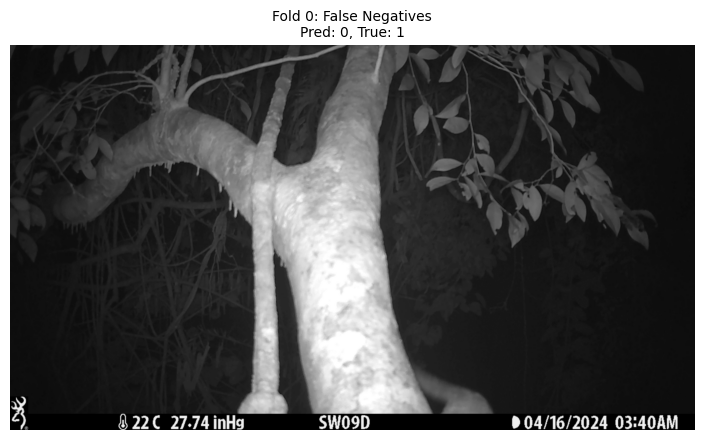

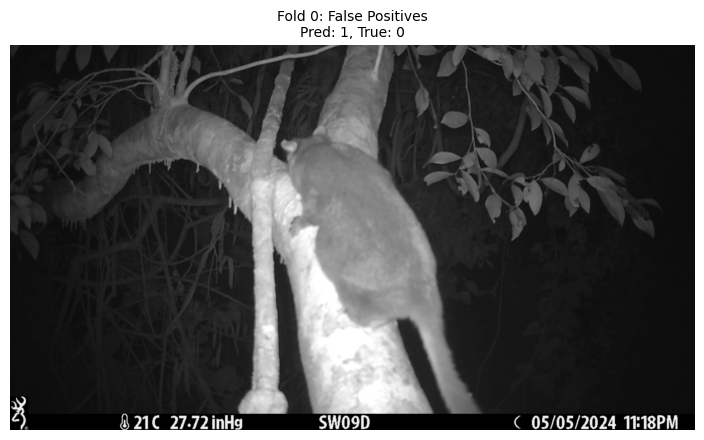



fold 2 -------------------------------------------------------------------------------------------------

epoch 1
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.77s/it]


	training loss: 0.6414
	pangolin accuracy: 0.7143
	pangolin precision: 0.0000
	pangolin recall: 0.0000
	pangolin f1-score: 0.0000
	pangolin auc: 0.8333
	other accuracy: 0.7143
	other precision: 0.7143
	other recall: 1.0000
	other f1-score: 0.8333
	other auc: 0.8333
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.37s/it]


	validation loss: 0.5897
	pangolin accuracy: 0.6792
	pangolin precision: 0.0000
	pangolin recall: 0.0000
	pangolin f1-score: 0.0000
	pangolin auc: 0.7729
	other accuracy: 0.6792
	other precision: 0.6792
	other recall: 1.0000
	other f1-score: 0.8090
	other auc: 0.7729

epoch 2
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.79s/it]


	training loss: 0.4777
	pangolin accuracy: 0.9524
	pangolin precision: 1.0000
	pangolin recall: 0.8333
	pangolin f1-score: 0.9091
	pangolin auc: 0.9778
	other accuracy: 0.9524
	other precision: 0.9375
	other recall: 1.0000
	other f1-score: 0.9677
	other auc: 0.9778
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.42s/it]


	validation loss: 0.4374
	pangolin accuracy: 0.7547
	pangolin precision: 0.6429
	pangolin recall: 0.5294
	pangolin f1-score: 0.5806
	pangolin auc: 0.9003
	other accuracy: 0.7547
	other precision: 0.7949
	other recall: 0.8611
	other f1-score: 0.8267
	other auc: 0.9003

epoch 3
TRAINING


100%|██████████| 15/15 [02:42<00:00, 10.80s/it]


	training loss: 0.3469
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.42s/it]


	validation loss: 0.3251
	pangolin accuracy: 0.8868
	pangolin precision: 0.7619
	pangolin recall: 0.9412
	pangolin f1-score: 0.8421
	pangolin auc: 0.9641
	other accuracy: 0.8868
	other precision: 0.9688
	other recall: 0.8611
	other f1-score: 0.9118
	other auc: 0.9641

epoch 4
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.77s/it]


	training loss: 0.2352
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.40s/it]


	validation loss: 0.2121
	pangolin accuracy: 0.9811
	pangolin precision: 0.9444
	pangolin recall: 1.0000
	pangolin f1-score: 0.9714
	pangolin auc: 0.9902
	other accuracy: 0.9811
	other precision: 1.0000
	other recall: 0.9722
	other f1-score: 0.9859
	other auc: 0.9902

epoch 5
TRAINING


100%|██████████| 15/15 [02:42<00:00, 10.82s/it]


	training loss: 0.1394
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.44s/it]


	validation loss: 0.1220
	pangolin accuracy: 0.9811
	pangolin precision: 0.9444
	pangolin recall: 1.0000
	pangolin f1-score: 0.9714
	pangolin auc: 1.0000
	other accuracy: 0.9811
	other precision: 1.0000
	other recall: 0.9722
	other f1-score: 0.9859
	other auc: 1.0000

epoch 6
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.74s/it]


	training loss: 0.0725
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.46s/it]


	validation loss: 0.0722
	pangolin accuracy: 0.9811
	pangolin precision: 0.9444
	pangolin recall: 1.0000
	pangolin f1-score: 0.9714
	pangolin auc: 1.0000
	other accuracy: 0.9811
	other precision: 1.0000
	other recall: 0.9722
	other f1-score: 0.9859
	other auc: 1.0000

epoch 7
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.77s/it]


	training loss: 0.0379
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.37s/it]


	validation loss: 0.0487
	pangolin accuracy: 0.9811
	pangolin precision: 0.9444
	pangolin recall: 1.0000
	pangolin f1-score: 0.9714
	pangolin auc: 1.0000
	other accuracy: 0.9811
	other precision: 1.0000
	other recall: 0.9722
	other f1-score: 0.9859
	other auc: 1.0000

epoch 8
TRAINING


100%|██████████| 15/15 [02:42<00:00, 10.82s/it]


	training loss: 0.0240
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:11<00:00,  5.62s/it]


	validation loss: 0.0312
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 9
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.80s/it]


	training loss: 0.0155
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.40s/it]


	validation loss: 0.0263
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 10
TRAINING


100%|██████████| 15/15 [02:40<00:00, 10.72s/it]


	training loss: 0.0122
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.42s/it]


	validation loss: 0.0212
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 11
TRAINING


100%|██████████| 15/15 [02:42<00:00, 10.85s/it]


	training loss: 0.0089
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.40s/it]


	validation loss: 0.0200
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 12
TRAINING


100%|██████████| 15/15 [02:45<00:00, 11.02s/it]


	training loss: 0.0083
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.36s/it]


	validation loss: 0.0172
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 13
TRAINING


100%|██████████| 15/15 [02:40<00:00, 10.73s/it]


	training loss: 0.0071
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.37s/it]


	validation loss: 0.0159
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 14
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.75s/it]


	training loss: 0.0057
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.29s/it]


	validation loss: 0.0147
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 15
TRAINING


100%|██████████| 15/15 [02:40<00:00, 10.72s/it]


	training loss: 0.0056
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.40s/it]


	validation loss: 0.0135
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
TESTING


100%|██████████| 5/5 [00:26<00:00,  5.24s/it]


	pangolin accuracy: 0.9924
	pangolin precision: 0.9762
	pangolin recall: 1.0000
	pangolin f1-score: 0.9880
	pangolin auc: 1.0000
	other accuracy: 0.9924
	other precision: 1.0000
	other recall: 0.9889
	other f1-score: 0.9944
	other auc: 1.0000
No Misclassified Samples Found: Fold 1: False Negatives


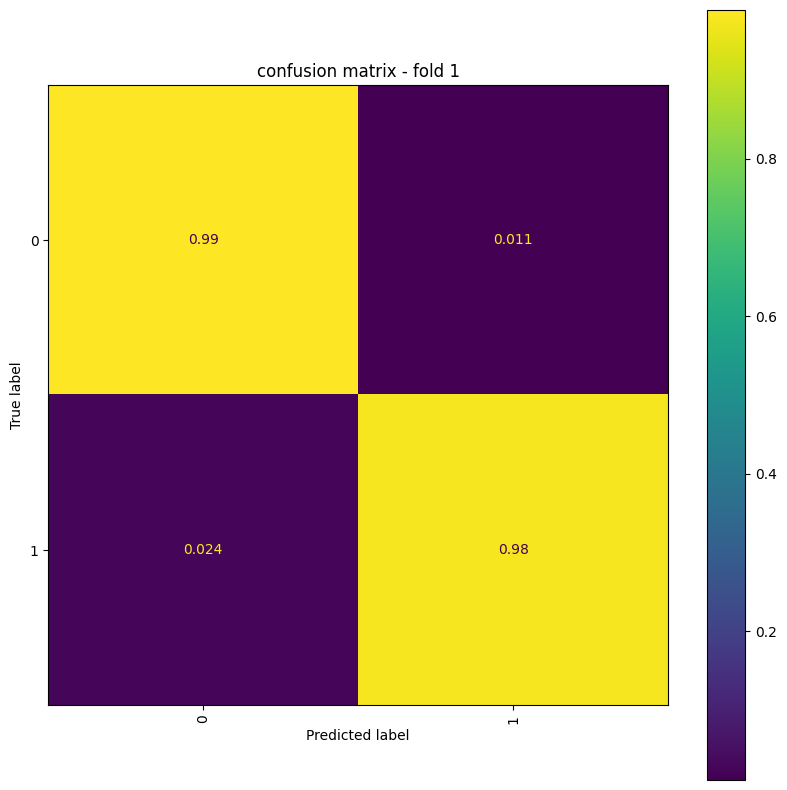

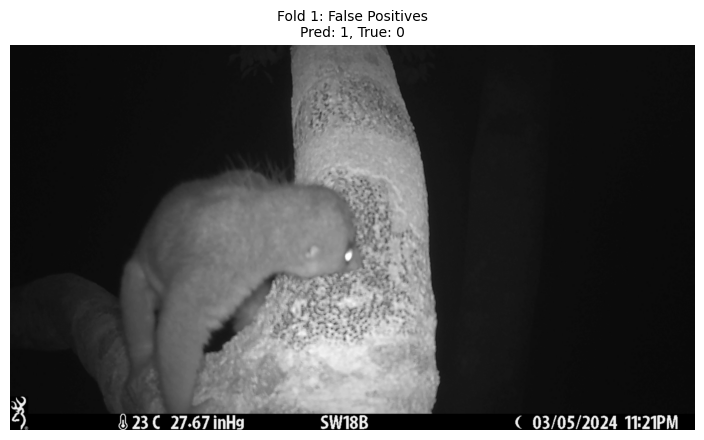



fold 3 -------------------------------------------------------------------------------------------------

epoch 1
TRAINING


100%|██████████| 15/15 [02:42<00:00, 10.80s/it]


	training loss: 0.6498
	pangolin accuracy: 0.7143
	pangolin precision: 0.0000
	pangolin recall: 0.0000
	pangolin f1-score: 0.0000
	pangolin auc: 0.8667
	other accuracy: 0.7143
	other precision: 0.7143
	other recall: 1.0000
	other f1-score: 0.8333
	other auc: 0.8667
VALIDATION


100%|██████████| 2/2 [00:11<00:00,  5.58s/it]


	validation loss: 0.5869
	pangolin accuracy: 0.6792
	pangolin precision: 0.0000
	pangolin recall: 0.0000
	pangolin f1-score: 0.0000
	pangolin auc: 0.8693
	other accuracy: 0.6792
	other precision: 0.6792
	other recall: 1.0000
	other f1-score: 0.8090
	other auc: 0.8693

epoch 2
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.77s/it]


	training loss: 0.4896
	pangolin accuracy: 0.7143
	pangolin precision: 0.0000
	pangolin recall: 0.0000
	pangolin f1-score: 0.0000
	pangolin auc: 0.9444
	other accuracy: 0.7143
	other precision: 0.7143
	other recall: 1.0000
	other f1-score: 0.8333
	other auc: 0.9444
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.49s/it]


	validation loss: 0.4169
	pangolin accuracy: 0.7736
	pangolin precision: 1.0000
	pangolin recall: 0.2941
	pangolin f1-score: 0.4545
	pangolin auc: 0.9820
	other accuracy: 0.7736
	other precision: 0.7500
	other recall: 1.0000
	other f1-score: 0.8571
	other auc: 0.9820

epoch 3
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.76s/it]


	training loss: 0.3619
	pangolin accuracy: 0.9048
	pangolin precision: 0.7500
	pangolin recall: 1.0000
	pangolin f1-score: 0.8571
	pangolin auc: 0.9889
	other accuracy: 0.9048
	other precision: 1.0000
	other recall: 0.8667
	other f1-score: 0.9286
	other auc: 0.9889
VALIDATION


100%|██████████| 2/2 [00:11<00:00,  5.50s/it]


	validation loss: 0.3027
	pangolin accuracy: 0.9434
	pangolin precision: 0.8889
	pangolin recall: 0.9412
	pangolin f1-score: 0.9143
	pangolin auc: 0.9918
	other accuracy: 0.9434
	other precision: 0.9714
	other recall: 0.9444
	other f1-score: 0.9577
	other auc: 0.9918

epoch 4
TRAINING


100%|██████████| 15/15 [02:42<00:00, 10.81s/it]


	training loss: 0.2630
	pangolin accuracy: 0.9048
	pangolin precision: 0.7500
	pangolin recall: 1.0000
	pangolin f1-score: 0.8571
	pangolin auc: 1.0000
	other accuracy: 0.9048
	other precision: 1.0000
	other recall: 0.8667
	other f1-score: 0.9286
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:11<00:00,  5.51s/it]


	validation loss: 0.2079
	pangolin accuracy: 0.9811
	pangolin precision: 0.9444
	pangolin recall: 1.0000
	pangolin f1-score: 0.9714
	pangolin auc: 0.9984
	other accuracy: 0.9811
	other precision: 1.0000
	other recall: 0.9722
	other f1-score: 0.9859
	other auc: 0.9984

epoch 5
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.78s/it]


	training loss: 0.1730
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.48s/it]


	validation loss: 0.1306
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 6
TRAINING


100%|██████████| 15/15 [02:42<00:00, 10.81s/it]


	training loss: 0.1046
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.45s/it]


	validation loss: 0.0791
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 7
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.80s/it]


	training loss: 0.0620
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.47s/it]


	validation loss: 0.0459
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 8
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.78s/it]


	training loss: 0.0370
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:11<00:00,  5.57s/it]


	validation loss: 0.0298
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 9
TRAINING


100%|██████████| 15/15 [02:42<00:00, 10.82s/it]


	training loss: 0.0235
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:11<00:00,  5.56s/it]


	validation loss: 0.0226
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 10
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.78s/it]


	training loss: 0.0185
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.47s/it]


	validation loss: 0.0166
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 11
TRAINING


100%|██████████| 15/15 [02:42<00:00, 10.82s/it]


	training loss: 0.0123
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:11<00:00,  5.54s/it]


	validation loss: 0.0139
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 12
TRAINING


100%|██████████| 15/15 [02:42<00:00, 10.82s/it]


	training loss: 0.0108
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:11<00:00,  5.52s/it]


	validation loss: 0.0112
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 13
TRAINING


100%|██████████| 15/15 [02:42<00:00, 10.82s/it]


	training loss: 0.0090
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:11<00:00,  5.50s/it]


	validation loss: 0.0096
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 14
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.76s/it]


	training loss: 0.0077
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:11<00:00,  5.52s/it]


	validation loss: 0.0082
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 15
TRAINING


100%|██████████| 15/15 [02:42<00:00, 10.81s/it]


	training loss: 0.0061
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.46s/it]


	validation loss: 0.0074
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
TESTING


100%|██████████| 5/5 [00:26<00:00,  5.27s/it]


	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
No Misclassified Samples Found: Fold 2: False Negatives
No Misclassified Samples Found: Fold 2: False Positives


fold 4 -------------------------------------------------------------------------------------------------

epoch 1
TRAINING


100%|██████████| 15/15 [02:40<00:00, 10.71s/it]


	training loss: 0.6607
	pangolin accuracy: 0.6818
	pangolin precision: 0.0000
	pangolin recall: 0.0000
	pangolin f1-score: 0.0000
	pangolin auc: 0.7905
	other accuracy: 0.6818
	other precision: 0.6818
	other recall: 1.0000
	other f1-score: 0.8108
	other auc: 0.7905
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.36s/it]


	validation loss: 0.5764
	pangolin accuracy: 0.6792
	pangolin precision: 0.0000
	pangolin recall: 0.0000
	pangolin f1-score: 0.0000
	pangolin auc: 0.8219
	other accuracy: 0.6792
	other precision: 0.6792
	other recall: 1.0000
	other f1-score: 0.8090
	other auc: 0.8219

epoch 2
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.74s/it]


	training loss: 0.4750
	pangolin accuracy: 0.9091
	pangolin precision: 1.0000
	pangolin recall: 0.7143
	pangolin f1-score: 0.8333
	pangolin auc: 0.9619
	other accuracy: 0.9091
	other precision: 0.8824
	other recall: 1.0000
	other f1-score: 0.9375
	other auc: 0.9619
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.33s/it]


	validation loss: 0.4262
	pangolin accuracy: 0.8113
	pangolin precision: 1.0000
	pangolin recall: 0.4118
	pangolin f1-score: 0.5833
	pangolin auc: 0.9526
	other accuracy: 0.8113
	other precision: 0.7826
	other recall: 1.0000
	other f1-score: 0.8780
	other auc: 0.9526

epoch 3
TRAINING


100%|██████████| 15/15 [02:40<00:00, 10.72s/it]


	training loss: 0.3527
	pangolin accuracy: 0.9545
	pangolin precision: 0.8750
	pangolin recall: 1.0000
	pangolin f1-score: 0.9333
	pangolin auc: 1.0000
	other accuracy: 0.9545
	other precision: 1.0000
	other recall: 0.9333
	other f1-score: 0.9655
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.35s/it]


	validation loss: 0.3221
	pangolin accuracy: 0.8491
	pangolin precision: 0.6957
	pangolin recall: 0.9412
	pangolin f1-score: 0.8000
	pangolin auc: 0.9886
	other accuracy: 0.8491
	other precision: 0.9667
	other recall: 0.8056
	other f1-score: 0.8788
	other auc: 0.9886

epoch 4
TRAINING


100%|██████████| 15/15 [02:40<00:00, 10.71s/it]


	training loss: 0.2490
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.31s/it]


	validation loss: 0.2333
	pangolin accuracy: 0.9434
	pangolin precision: 0.8889
	pangolin recall: 0.9412
	pangolin f1-score: 0.9143
	pangolin auc: 0.9918
	other accuracy: 0.9434
	other precision: 0.9714
	other recall: 0.9444
	other f1-score: 0.9577
	other auc: 0.9918

epoch 5
TRAINING


100%|██████████| 15/15 [02:40<00:00, 10.71s/it]


	training loss: 0.1640
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.39s/it]


	validation loss: 0.1517
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 6
TRAINING


100%|██████████| 15/15 [02:40<00:00, 10.70s/it]


	training loss: 0.0978
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.35s/it]


	validation loss: 0.0909
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 7
TRAINING


100%|██████████| 15/15 [02:40<00:00, 10.71s/it]


	training loss: 0.0553
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.41s/it]


	validation loss: 0.0570
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 8
TRAINING


100%|██████████| 15/15 [02:40<00:00, 10.71s/it]


	training loss: 0.0332
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.34s/it]


	validation loss: 0.0379
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 9
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.76s/it]


	training loss: 0.0218
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.35s/it]


	validation loss: 0.0277
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 10
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.74s/it]


	training loss: 0.0157
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.38s/it]


	validation loss: 0.0226
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 11
TRAINING


100%|██████████| 15/15 [02:40<00:00, 10.72s/it]


	training loss: 0.0114
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.34s/it]


	validation loss: 0.0182
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 12
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.78s/it]


	training loss: 0.0100
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.31s/it]


	validation loss: 0.0156
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 13
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.75s/it]


	training loss: 0.0085
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.33s/it]


	validation loss: 0.0139
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 14
TRAINING


100%|██████████| 15/15 [02:40<00:00, 10.72s/it]


	training loss: 0.0072
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.37s/it]


	validation loss: 0.0125
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 15
TRAINING


100%|██████████| 15/15 [02:40<00:00, 10.71s/it]


	training loss: 0.0061
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.31s/it]


	validation loss: 0.0106
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
TESTING


100%|██████████| 5/5 [00:25<00:00,  5.09s/it]


	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
No Misclassified Samples Found: Fold 3: False Negatives
No Misclassified Samples Found: Fold 3: False Positives


fold 5 -------------------------------------------------------------------------------------------------

epoch 1
TRAINING


100%|██████████| 15/15 [02:38<00:00, 10.55s/it]


	training loss: 0.6278
	pangolin accuracy: 0.6818
	pangolin precision: 0.0000
	pangolin recall: 0.0000
	pangolin f1-score: 0.0000
	pangolin auc: 0.9048
	other accuracy: 0.6818
	other precision: 0.6818
	other recall: 1.0000
	other f1-score: 0.8108
	other auc: 0.9048
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.23s/it]


	validation loss: 0.5623
	pangolin accuracy: 0.6792
	pangolin precision: 0.0000
	pangolin recall: 0.0000
	pangolin f1-score: 0.0000
	pangolin auc: 0.8529
	other accuracy: 0.6792
	other precision: 0.6792
	other recall: 1.0000
	other f1-score: 0.8090
	other auc: 0.8529

epoch 2
TRAINING


100%|██████████| 15/15 [02:41<00:00, 10.75s/it]


	training loss: 0.4501
	pangolin accuracy: 0.8636
	pangolin precision: 1.0000
	pangolin recall: 0.5714
	pangolin f1-score: 0.7273
	pangolin auc: 0.9619
	other accuracy: 0.8636
	other precision: 0.8333
	other recall: 1.0000
	other f1-score: 0.9091
	other auc: 0.9619
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.31s/it]


	validation loss: 0.4356
	pangolin accuracy: 0.7736
	pangolin precision: 0.8571
	pangolin recall: 0.3529
	pangolin f1-score: 0.5000
	pangolin auc: 0.9232
	other accuracy: 0.7736
	other precision: 0.7609
	other recall: 0.9722
	other f1-score: 0.8537
	other auc: 0.9232

epoch 3
TRAINING


100%|██████████| 15/15 [02:39<00:00, 10.64s/it]


	training loss: 0.3358
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.24s/it]


	validation loss: 0.3429
	pangolin accuracy: 0.9434
	pangolin precision: 0.9375
	pangolin recall: 0.8824
	pangolin f1-score: 0.9091
	pangolin auc: 0.9804
	other accuracy: 0.9434
	other precision: 0.9459
	other recall: 0.9722
	other f1-score: 0.9589
	other auc: 0.9804

epoch 4
TRAINING


100%|██████████| 15/15 [02:39<00:00, 10.66s/it]


	training loss: 0.2434
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.29s/it]


	validation loss: 0.2391
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 5
TRAINING


100%|██████████| 15/15 [02:39<00:00, 10.64s/it]


	training loss: 0.1614
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.30s/it]


	validation loss: 0.1456
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 6
TRAINING


100%|██████████| 15/15 [02:39<00:00, 10.65s/it]


	training loss: 0.0957
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.25s/it]


	validation loss: 0.0856
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 7
TRAINING


100%|██████████| 15/15 [02:40<00:00, 10.71s/it]


	training loss: 0.0529
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.27s/it]


	validation loss: 0.0542
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 8
TRAINING


100%|██████████| 15/15 [02:40<00:00, 10.69s/it]


	training loss: 0.0320
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.24s/it]


	validation loss: 0.0410
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 9
TRAINING


100%|██████████| 15/15 [02:39<00:00, 10.64s/it]


	training loss: 0.0230
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.22s/it]


	validation loss: 0.0315
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 10
TRAINING


100%|██████████| 15/15 [02:38<00:00, 10.58s/it]


	training loss: 0.0165
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.25s/it]


	validation loss: 0.0283
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 11
TRAINING


100%|██████████| 15/15 [02:37<00:00, 10.50s/it]


	training loss: 0.0122
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.22s/it]


	validation loss: 0.0250
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000

epoch 12
TRAINING


100%|██████████| 15/15 [02:38<00:00, 10.55s/it]


	training loss: 0.0101
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.21s/it]


	validation loss: 0.0229
	pangolin accuracy: 0.9811
	pangolin precision: 0.9444
	pangolin recall: 1.0000
	pangolin f1-score: 0.9714
	pangolin auc: 1.0000
	other accuracy: 0.9811
	other precision: 1.0000
	other recall: 0.9722
	other f1-score: 0.9859
	other auc: 1.0000

epoch 13
TRAINING


100%|██████████| 15/15 [02:38<00:00, 10.58s/it]


	training loss: 0.0092
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.26s/it]


	validation loss: 0.0213
	pangolin accuracy: 0.9811
	pangolin precision: 0.9444
	pangolin recall: 1.0000
	pangolin f1-score: 0.9714
	pangolin auc: 1.0000
	other accuracy: 0.9811
	other precision: 1.0000
	other recall: 0.9722
	other f1-score: 0.9859
	other auc: 1.0000

epoch 14
TRAINING


100%|██████████| 15/15 [02:38<00:00, 10.55s/it]


	training loss: 0.0076
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.18s/it]


	validation loss: 0.0202
	pangolin accuracy: 0.9811
	pangolin precision: 0.9444
	pangolin recall: 1.0000
	pangolin f1-score: 0.9714
	pangolin auc: 1.0000
	other accuracy: 0.9811
	other precision: 1.0000
	other recall: 0.9722
	other f1-score: 0.9859
	other auc: 1.0000

epoch 15
TRAINING


100%|██████████| 15/15 [02:38<00:00, 10.58s/it]


	training loss: 0.0064
	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
VALIDATION


100%|██████████| 2/2 [00:10<00:00,  5.24s/it]


	validation loss: 0.0194
	pangolin accuracy: 0.9811
	pangolin precision: 0.9444
	pangolin recall: 1.0000
	pangolin f1-score: 0.9714
	pangolin auc: 1.0000
	other accuracy: 0.9811
	other precision: 1.0000
	other recall: 0.9722
	other f1-score: 0.9859
	other auc: 1.0000
TESTING


100%|██████████| 5/5 [00:25<00:00,  5.10s/it]


	pangolin accuracy: 1.0000
	pangolin precision: 1.0000
	pangolin recall: 1.0000
	pangolin f1-score: 1.0000
	pangolin auc: 1.0000
	other accuracy: 1.0000
	other precision: 1.0000
	other recall: 1.0000
	other f1-score: 1.0000
	other auc: 1.0000
No Misclassified Samples Found: Fold 4: False Negatives
No Misclassified Samples Found: Fold 4: False Positives


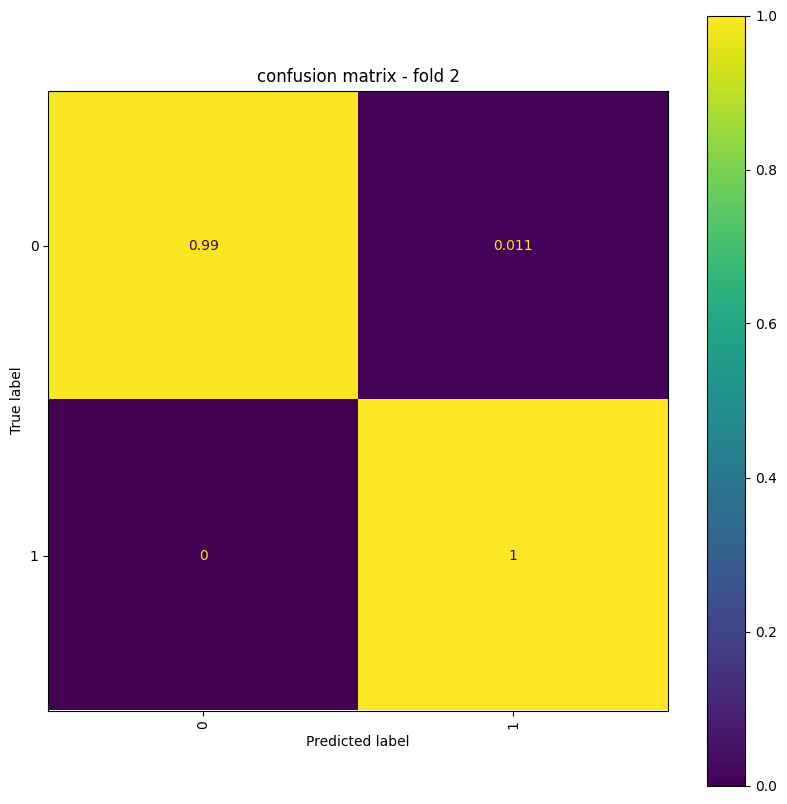

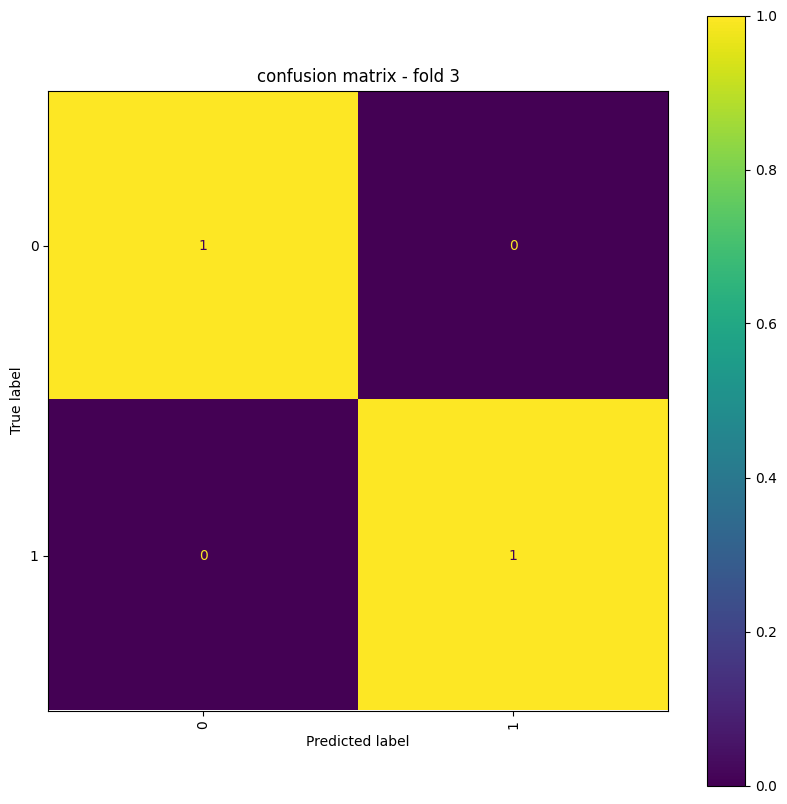

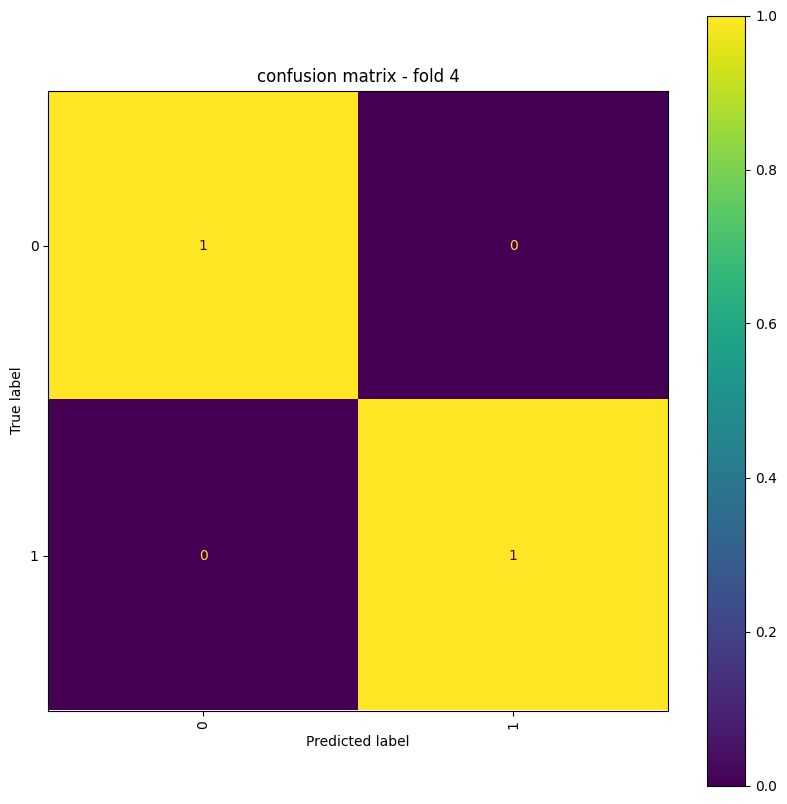

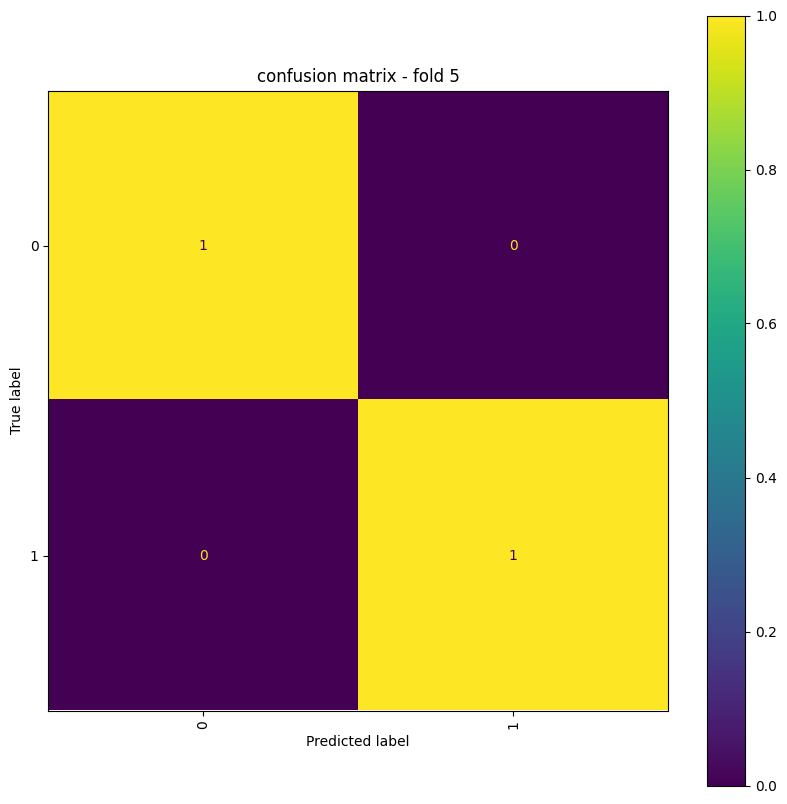

In [ ]:
for fold in df_splits["fold"].unique():    
    # get the stored indices 
    train_index = df_splits[(df_splits["fold"] == fold) & (df_splits["type"] == "train")]["index"].values
    val_index = df_splits[(df_splits["fold"] == fold) & (df_splits["type"] == "val")]["index"].values
    test_index = df_splits[(df_splits["fold"] == fold) & (df_splits["type"] == "test")]["index"].values

    print(f"\n\nfold {fold + 1} -------------------------------------------------------------------------------------------------")

    min_val_loss = sys.float_info.max
    model_name = "model_fold" + str(fold + 1) + ".pth"
    model_path = model_folder_path + "/" + model_name       # path to store the model checkpoints, name-specific to fold

    # split data and get dataloaders
    train_data = [data[i] for i in train_index]
    val_data = [data[i] for i in val_index]
    test_data = [data[i] for i in test_index]

    train_dataset = ImagesDataset(train_data)
    val_dataset = ImagesDataset(val_data)
    test_dataset = ImagesDataset(test_data)

    train_dataloader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn)
    val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)
    test_dataloader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

    # load model
    model = models.resnet50(pretrained=True)
    model.load_state_dict(torch.load(pretrained_model, map_location=torch.device('cpu')), strict=False)
    model.fc = nn.Sequential(
        nn.Linear(2048, 100),  # dense layer takes a 2048-dim input and outputs 100-dim
        nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
        nn.Dropout(0.1),  # common technique to mitigate overfitting
        nn.Linear(
            100, 2
        ),  # final dense layer outputs 8-dim corresponding to our target classes
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(1, num_epochs + 1):
        start_time = time.time()

        print(f"\nepoch {epoch}")

        #############################################################################################################################################
        # training
        #############################################################################################################################################
        print("TRAINING")

        model.train()

        tracking_loss = {}
        training_loss = 0
        training_num_loss = 0

        # iterate through the dataloader batches. tqdm keeps track of progress.
        for batch_n, batch in tqdm(
            enumerate(train_dataloader), total=len(train_dataloader)
        ):
            # 1) zero out the parameter gradients so that gradients from previous batches are not used in this step
            optimizer.zero_grad()

            # 2) run the foward step on this batch of images
            outputs = model(batch["image"])

            # 3) compute the loss
            loss = criterion(outputs, batch["label"])
            training_loss += loss.item()
            training_num_loss += 1

            # let's keep track of the loss by epoch
            tracking_loss[epoch] = loss.item()

            # 4) compute our gradients
            loss.backward()
            # update our weights
            optimizer.step()

        _, train_pred = torch.max(outputs, 1)                       # get the predicted labels
        train_prob = torch.nn.functional.softmax(outputs, dim=1)    # get the probability of the positive and negative class
        train_true = batch["label"]                                 # get the true labels

        # print and log scores
        training_loss /= training_num_loss
        print(f"\ttraining loss: {training_loss:.4f}")
        train_print_and_log_scores(fold, epoch, train_true, train_pred, train_prob)

        #############################################################################################################################################
        # validation
        #############################################################################################################################################
        print("VALIDATION")

        preds_collector = []
        model.eval()

        val_loss = 0.0
        val_num_loss = 0

        # iterate through dataloader and run the model
        with torch.no_grad():
            for batch in tqdm(val_dataloader, total=len(val_dataloader)):
                logits = model.forward(batch["image"])

                loss = criterion(logits, batch["label"])
                val_loss += loss.item()
                val_num_loss += 1

                preds = nn.functional.softmax(logits, dim=1)
                preds_df = pd.DataFrame(
                    preds.detach().numpy(),
                    index=batch["image_id"],
                    columns=[0, 1],
                )
                preds_collector.append(preds_df)

        val_preds_df = pd.concat(preds_collector)
        val_preds = val_preds_df.idxmax(axis=1)         # get the predicted labels
        val_true = [label for _, label in val_data]     # get the true labels
        val_prob = val_preds_df.values                  # get the probability of the positive and negative class

        # print scores
        val_loss /= val_num_loss
        print(f"\tvalidation loss: {val_loss:.4f}")
        print_scores(val_true, val_preds, val_prob)

        # log train and val loss
        loss_writer.writerow([fold, epoch, training_loss, val_loss])

        # check if the current epoch is most optimal based on the current minimum validation loss
        if val_loss < min_val_loss:
            # save model checkpoint to folder
            model_path = os.path.join(model_folder_path, model_name)
            torch.save(model.state_dict(), model_path)

            # update min validation loss value
            min_val_loss = val_loss

        # get and log the elapsed time for current epoch
        epoch_time = time.time() - start_time
        time_writer.writerow([fold, epoch, epoch_time])


    #############################################################################################################################################
    # testing
    #############################################################################################################################################
    print("TESTING")

    loaded_model = torch.load(model_path)

    preds_collector = []
    model.eval()

    # iterate through dataloader and run the model
    with torch.no_grad():
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            logits = model.forward(batch["image"])
            preds = nn.functional.softmax(logits, dim=1)
            preds_df = pd.DataFrame(
                preds.detach().numpy(),
                index=batch["image_id"],
                columns=[0, 1],
            )
            preds_collector.append(preds_df)

    test_preds_df = pd.concat(preds_collector)
    test_preds = test_preds_df.idxmax(axis=1)       # get the predicted labels
    test_true = [label for _, label in test_data]   # get the true labels
    test_prob = test_preds_df.values                # get the probability of the positive and negative class 

    # print and log scores
    test_print_and_log_scores(fold, test_true, test_preds, test_prob)

    # error analysis on misclassified images
    plot_misclassified(fold, test_preds, test_data)

    # display confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.title("confusion matrix - fold " + str(fold + 1))
    cm = ConfusionMatrixDisplay.from_predictions(
        test_true,
        test_preds_df.idxmax(axis=1),
        ax=ax,
        xticks_rotation=90,
        colorbar=True,
        normalize='true'
    )

    # flush writes to logging files
    train_csv.flush()
    time_csv.flush()
    test_csv.flush()
    loss_csv.flush()


In [11]:
train_csv.flush()
time_csv.flush()
test_csv.flush()
loss_csv.flush()

train_csv.close()
time_csv.close()
test_csv.close()
loss_csv.close()